In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'differential_apa_c2c12',
        root = '..',
    )

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from lapa.result import LapaResult
import matplotlib.pyplot as plt

sns.set_context('poster')

In [3]:
result = LapaResult(snakemake.input['long_read'])
samples = result.samples

In [4]:
df = result.fisher_exact_test({'undif': ['PB154', 'PB155'], 'dif': ['PB213', 'PB214']}, min_gene_count=50)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9397/9397 [00:51<00:00, 183.85it/s]


In [5]:
df['-log10(p-value corrected)'] = -np.log10(df['pval_adj'])

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
df = df.reset_index().rename(columns={'index': 'polya_site'})
df = df.merge(pd.read_csv(snakemake.input['mapping']), on='gene_id')

In [7]:
df.loc[df['-log10(p-value corrected)'] == np.inf, '-log10(p-value corrected)'] = 300

In [8]:
df = df.loc[df.groupby('gene_id')['pval_adj'].idxmin()]

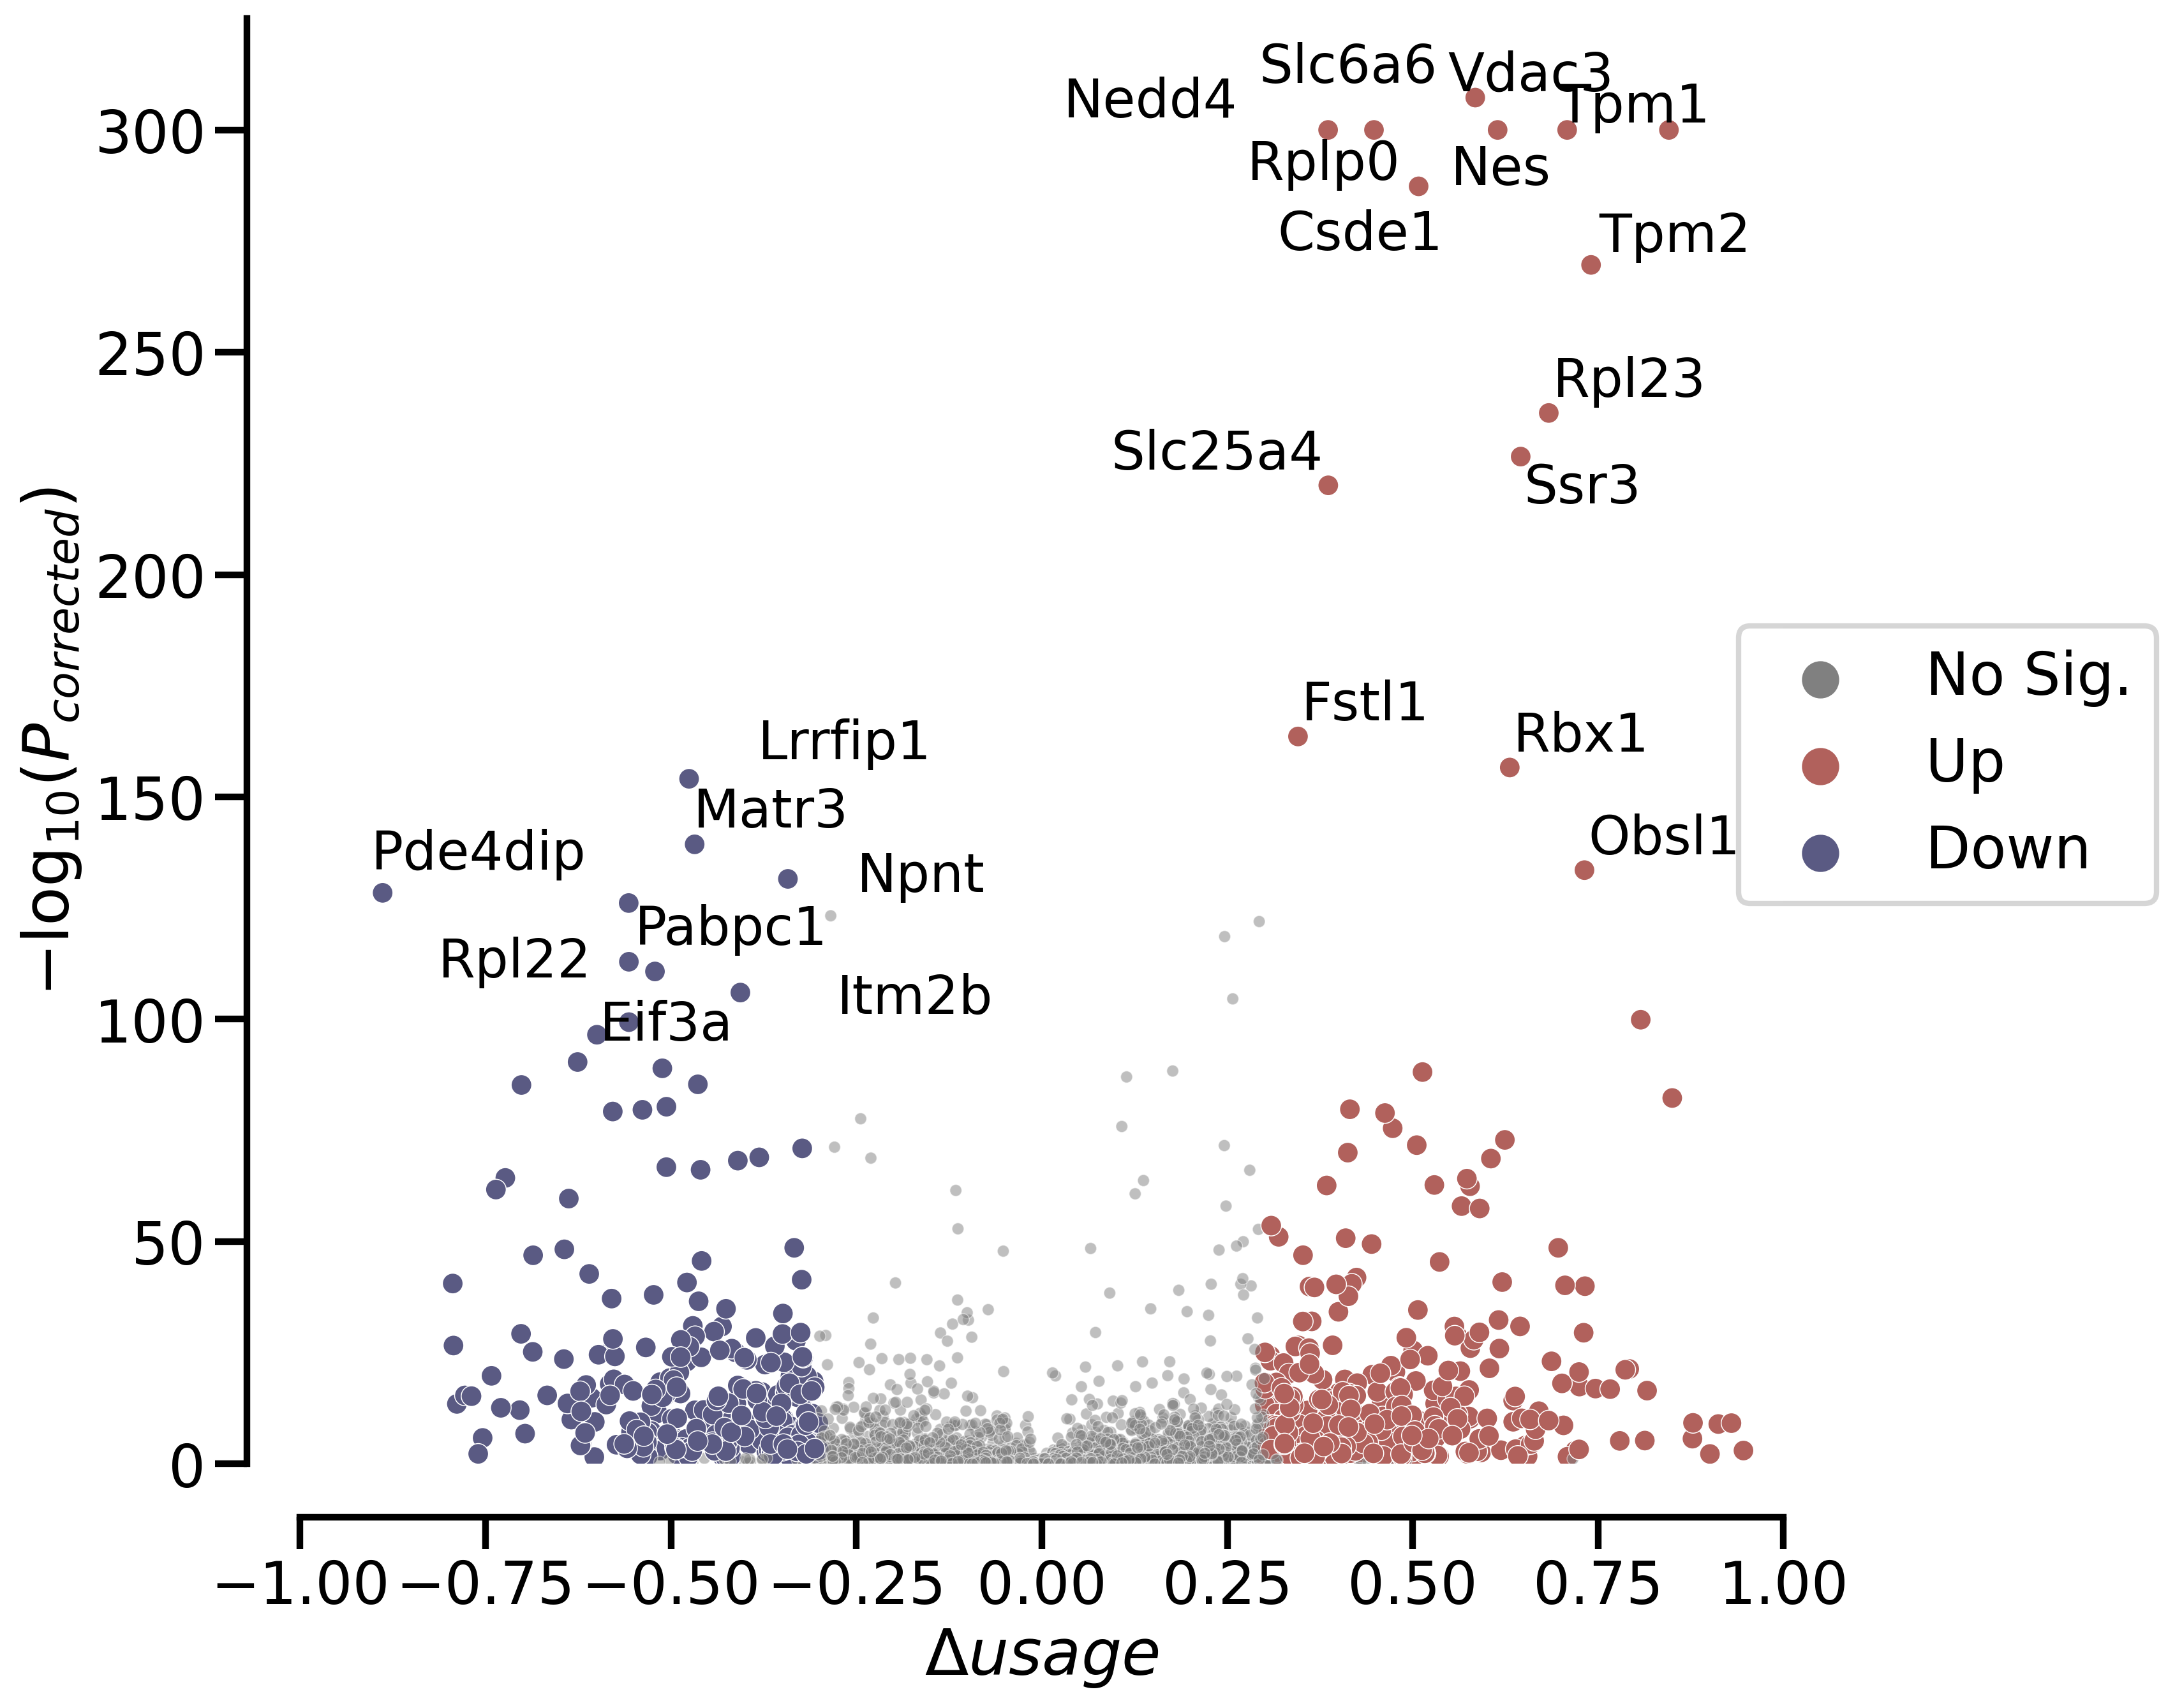

In [9]:
from adjustText import adjust_text

df['significant'] = np.where(
    (df['delta_usage'].abs() > 0.3) & (df['pval_adj'] < 0.05),
    np.where(df['delta_usage'] > 0.3, 'Up', 'Down'),
    'No Sig.'
)

plt.figure(dpi=300, figsize=(10, 10))

sns.scatterplot(data=df, x='delta_usage', y='-log10(p-value corrected)', hue='significant',
                s = 40 * (df['significant'] != 'No Sig.') + 20, 
                palette = ['gray', '#b1615c', '#5a5a83'], 
                alpha = list(0.5 + (df['significant'] != 'No Sig.') * 0.5))

plt.legend(title=None, bbox_to_anchor=(0.95, 0.6))
plt.xlabel('$\Delta usage$')
plt.ylabel('$-\log_{10}(P_{corrected})$')

_df = df[(df['delta_usage'].abs() > 0.3) & (df['-log10(p-value corrected)'] > 100)]

text = [
    plt.text(row['delta_usage'], row['-log10(p-value corrected)'], row['gene_name'], fontsize=20)
    for _, row in _df.iterrows()
]
adjust_text(text)
sns.despine(offset=20, trim=False)

plt.xlim(-1, 1)
plt.ylim(0, 325)

plt.savefig(snakemake.output['volcona_plot'], dpi=400, bbox_inches='tight', transparent=True)

In [10]:
df = df[(df['pval_adj'] < 0.05) & (df['delta_usage'].abs() > 0.3)]

In [11]:
df.sort_values('delta_usage')

,polya_site,odds_ratio,pval,delta_usage,gene_id,pval_adj,-log10(p-value corrected),gene_name,significant
5963,chr3:97689828:-,0.003576,1.150580e-131,-0.888808,ENSMUSG00000038170.15,3.728275e-129,128.428492,Pde4dip,Down
4808,chr2:126791568:-,0.011372,4.707720e-43,-0.794284,ENSMUSG00000027365.14,2.714015e-41,40.566388,Trpm7,Down
5871,chr3:87078600:-,0.007934,6.685585e-29,-0.793285,ENSMUSG00000041734.15,2.388762e-27,26.621827,Kirrel,Down
2444,chr15:56665629:-,0.013801,2.047022e-15,-0.788701,ENSMUSG00000022367.7,3.227494e-14,13.491135,Has2,Down
4179,chr1:162671793:-,0.017241,2.165108e-17,-0.777894,ENSMUSG00000040225.15,3.965988e-16,15.401649,Prrc2c,Down
...,...,...,...,...,...,...,...,...,...
2370,chr15:27547699:-,353.600000,5.552856e-11,0.877914,ENSMUSG00000046034.8,5.936312e-10,9.226483,Otulin,Up
7779,chr7:132714201:-,inf,1.665696e-03,0.900777,ENSMUSG00000030956.15,5.833971e-03,2.234036,Fam53b,Up
1745,chr13:51701248:-,inf,1.038712e-10,0.912021,ENSMUSG00000021451.16,1.078794e-09,8.967062,Sema4d,Up
1167,chr11:96965049:+,inf,6.389192e-11,0.929762,ENSMUSG00000078700.10,6.791769e-10,9.168017,D030028A08Rik,Up


In [12]:
usage = result.attribute('usage').loc[df['polya_site']][['PB154', 'PB155', 'PB213', 'PB214']]

In [13]:
colors = ['#5a5a83', '#7d7da5', '#9696c0', '#b8b8d5', '#dbd0db', '#e9c6c6', '#e0a29e', '#d3827d', '#b1615c']
col_colors = ['#c08e39', '#022a2a']

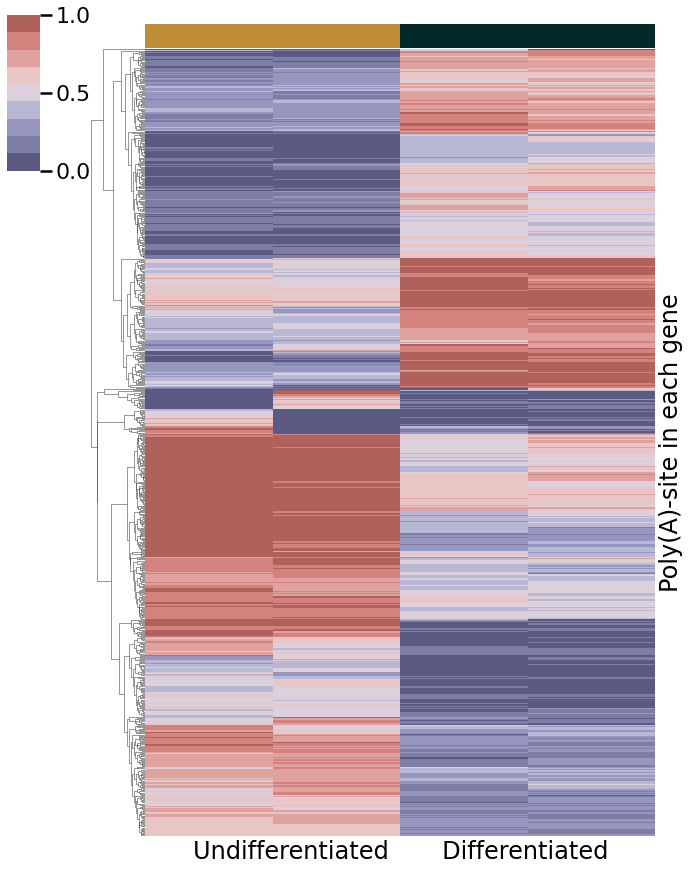

In [14]:
import seaborn as sns
import matplotlib.patches as mpatches


fig = sns.clustermap(usage.fillna(0), figsize=(9, 12),
                     col_colors=[col_colors[0], col_colors[0], col_colors[1], col_colors[1]],
                     xticklabels=False, yticklabels=False, col_cluster=False,
                     cmap=sns.color_palette(colors, as_cmap=True), 
                     cbar_pos=(-0.085, 0.8, 0.05, 0.18), dendrogram_ratio=(0.1, 0))

fig.ax_heatmap.set_xlabel('Undifferentiated' + ' ' * 7 +'Differentiated')
fig.ax_heatmap.set_ylabel('Poly(A)-site in each gene')

plt.savefig(snakemake.output['heatmap_plot'], dpi=400, bbox_inches='tight', transparent=True)